In [1]:
pip install --user shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import numpy as np
import pandas
from shap import TreeExplainer, summary_plot
from sklearn import preprocessing
from tqdm import tqdm

In [3]:
#Import scikit-learn dataset library
from sklearn import datasets

In [4]:
import pandas as pd
PollPlants = pd.read_csv ('D:/BiCIKL_UseCase/CPC-Pollinator common name/PollPlantsGBIF2.csv')
print('PollPlants data set has got {} rows and {} columns'.format(PollPlants.shape[0],PollPlants.shape[1]))
PollPlants.head()

PollPlants data set has got 79990 rows and 21 columns


,pollinator_scientific,pollinator_taxonKey,pollinator_scientificName,pollinator_kingdom,pollinator_phylum,pollinator_order,pollinator_family,pollinator_genus,pollinator_species,pollinator_country,...,plant_taxonKey,plant_scientificName,plant_kingdom,plant_phylum,plant_order,plant_family,plant_genus,plant_species,plant_country,class
0,Bombus sylvicola,https://www.gbif.org/species/1340525,"Bombus sylvicola Kirby, 1837",Animalia,Arthropoda,Hymenoptera,Apidae,Bombus,Bombus sylvicola,Canada,...,https://www.gbif.org/species/5384898,Abronia ammophila Greene,Plantae,Tracheophyta,Caryophyllales,Nyctaginaceae,Abronia,Abronia ammophila,United States of America,1
1,Bombus mixtus,https://www.gbif.org/species/1340485,"Bombus mixtus Cresson, 1879",Animalia,Arthropoda,Hymenoptera,Apidae,Bombus,Bombus mixtus,Canada,...,https://www.gbif.org/species/5384898,Abronia ammophila Greene,Plantae,Tracheophyta,Caryophyllales,Nyctaginaceae,Abronia,Abronia ammophila,United States of America,1
2,Hyles lineata,https://www.gbif.org/species/1862841,"Hyles lineata Fabricius, 1775",Animalia,Arthropoda,Lepidoptera,Sphingidae,Hyles,Hyles lineata,Mexico,...,https://www.gbif.org/species/5384898,Abronia ammophila Greene,Plantae,Tracheophyta,Caryophyllales,Nyctaginaceae,Abronia,Abronia ammophila,United States of America,1
3,Pontia occidentalis,https://www.gbif.org/species/5137791,"Pontia occidentalis (Reakirt, 1866)",Animalia,Arthropoda,Lepidoptera,Pieridae,Pontia,Pontia occidentalis,United States of America,...,https://www.gbif.org/species/5384898,Abronia ammophila Greene,Plantae,Tracheophyta,Caryophyllales,Nyctaginaceae,Abronia,Abronia ammophila,United States of America,1
4,Hada sutrina,https://www.gbif.org/species/1761076,"Hada sutrina Grote, 1881",Animalia,Arthropoda,Lepidoptera,Noctuidae,Hada,Hada sutrina,Canada,...,https://www.gbif.org/species/5384898,Abronia ammophila Greene,Plantae,Tracheophyta,Caryophyllales,Nyctaginaceae,Abronia,Abronia ammophila,United States of America,1


In [5]:
corrupted_path = "D:/BiCIKL_UseCase/CPC-Pollinator common name/corrupted.csv"

In [6]:
if not os.path.exists(corrupted_path):
    PollPlants = PollPlants[PollPlants["class"] == 1]
    corrupted_dataset = PollPlants.copy()
    print(len(PollPlants))

In [7]:
# randomly replace the plant for each pollinator
unique_plants = set(PollPlants.plant_scientific.unique())
print(len(unique_plants))

2535


In [8]:
for r, row in tqdm(PollPlants.iterrows(), total=len(PollPlants)):
    # sample a new plant, which is not the same
    sampled_plant = np.random.choice(list(unique_plants - {row.plant_scientific}), size=1)[0]
    # get row for sampled plant to get all the columns for that plant
    rows_for_sampled_plant = PollPlants[PollPlants.plant_scientific == sampled_plant].reset_index()
    # print(rows_for_sampled_plant.head())
    for column in PollPlants.columns:
        if "plant" in column:
            corrupted_dataset.loc[r, column] = rows_for_sampled_plant.loc[0, column]
            corrupted_dataset.to_csv(corrupted_path, index=False)
        else:
            corrupted_dataset = pandas.read_csv(corrupted_path)
            corrupted_dataset["class"] = 0
            # replace the PollPlants dataset with the correct and corrupted rows
            PollPlants = pandas.concat([PollPlants[PollPlants["class"] == 1], corrupted_dataset])
            PollPlants.to_csv("D:/BiCIKL_UseCase/CPC-Pollinator common name/corrupted_and_correct.csv", index=False)

  0%|          | 1/79990 [00:34<777:14:26, 34.98s/it]


KeyError: 0

In [9]:
PollPlants_drop = PollPlants.drop(
        columns=['pollinator_species', 'plant_species'])  # 2 columns will not be used to train the algorithm, so we drop them

In [10]:
PollPlants_drop.info()  # some of the columns contain nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79990 entries, 0 to 39994
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   pollinator_scientific      79990 non-null  object
 1   pollinator_taxonKey        79990 non-null  object
 2   pollinator_scientificName  79990 non-null  object
 3   pollinator_kingdom         79990 non-null  object
 4   pollinator_phylum          79990 non-null  object
 5   pollinator_order           79990 non-null  object
 6   pollinator_family          79970 non-null  object
 7   pollinator_genus           79544 non-null  object
 8   pollinator_country         79958 non-null  object
 9   plant_scientific           79990 non-null  object
 10  plant_taxonKey             79990 non-null  object
 11  plant_scientificName       79990 non-null  object
 12  plant_kingdom              79990 non-null  object
 13  plant_phylum               79990 non-null  object
 14  plant_

In [11]:
PollPlants_drop2 = PollPlants_drop.dropna()

In [12]:
PollPlants_drop2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79512 entries, 0 to 39994
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   pollinator_scientific      79512 non-null  object
 1   pollinator_taxonKey        79512 non-null  object
 2   pollinator_scientificName  79512 non-null  object
 3   pollinator_kingdom         79512 non-null  object
 4   pollinator_phylum          79512 non-null  object
 5   pollinator_order           79512 non-null  object
 6   pollinator_family          79512 non-null  object
 7   pollinator_genus           79512 non-null  object
 8   pollinator_country         79512 non-null  object
 9   plant_scientific           79512 non-null  object
 10  plant_taxonKey             79512 non-null  object
 11  plant_scientificName       79512 non-null  object
 12  plant_kingdom              79512 non-null  object
 13  plant_phylum               79512 non-null  object
 14  plant_

In [13]:
# Separate the columns into independent and dependent variables (or features and labels).

# Import train_test_split function
from sklearn.model_selection import train_test_split

X = PollPlants_drop2[
        ['pollinator_scientific', 'pollinator_taxonKey', 'pollinator_scientificName', 'pollinator_kingdom', 'pollinator_phylum',
         'pollinator_order', 'pollinator_family', 'pollinator_genus', 'pollinator_country', 'plant_scientific', 'plant_taxonKey',
         'plant_scientificName', 'plant_kingdom', 'plant_phylum', 'plant_order', 'plant_family', 'plant_genus',
         'plant_country']]  # Features
y = PollPlants_drop2['class']  # Labels

In [14]:
for column in X.columns:
    print(column)
    # make a map (dict) from unique values to integer values
    str_to_int = {value: i for i, value in enumerate(sorted(list(X[column].unique())))}
    print(str_to_int)
    # create column with ints
    X[column + "_int"] = X[column].apply(lambda val: str_to_int[val])
    del X[column]  # remove original column (with strings)
X.to_csv("D:/BiCIKL_UseCase/CPC-Pollinator common name/mapped.csv", index=False)

pollinator_scientific
{'Abaeis nicippe': 0, 'Acanthoscelides': 1, 'Acanthoscelides fraterculus': 2, 'Acanthoscelides pauperculus': 3, 'Acmaeodera angelica': 4, 'Acmaeodera fenyesi': 5, 'Acmaeodera idahoensis': 6, 'Acmaeodera pulchella': 7, 'Acmaeodera retifera': 8, 'Acmaeops pratensis': 9, 'Actia pilipennis': 10, 'Adejeania vexatrix': 11, 'Adela flammeusella': 12, 'Adela trigrapha': 13, 'Adopaeoides prittwitzi': 14, 'Agapostemon angelicus': 15, 'Agapostemon coloradinus': 16, 'Agapostemon melliventris': 17, 'Agapostemon splendens': 18, 'Agapostemon texanus': 19, 'Agapostemon tyleri': 20, 'Agapostemon virescens': 21, 'Agapostemon viridulus': 22, 'Agathis brevicornis': 23, 'Aglais milberti': 24, 'Agraulis vanillae': 25, 'Agrilus sierrae': 26, 'Aleochara': 27, 'Allograpta exotica': 28, 'Allograpta obliqua': 29, 'Alydus eurinus': 30, 'Alydus pilosulus': 31, 'Alypia octomaculata': 32, 'Amazilia tzacatl': 33, 'Amblyscirtes aenus': 34, 'Amblyscirtes nysa': 35, 'Amegilla fallax': 36, 'Amegilla 

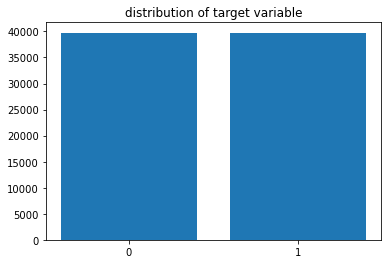

In [15]:
import matplotlib.pyplot as plt

x=y.value_counts()
plt.bar(x.index,x)
plt.gca().set_xticks([0,1])
plt.title('distribution of target variable')
plt.show()

In [16]:
print('PollPlants_drop2 data set has got {} rows and {} columns'.format(PollPlants_drop2.shape[0],PollPlants_drop2.shape[1]))

PollPlants_drop2 data set has got 79512 rows and 19 columns


In [17]:
x = isinstance(X, pd.DataFrame)

print(x)

True


In [18]:
X = X.values  # turn DataFrame into a numpy matrix
print(X.shape)
# normalize values = numerical input variables are scaled to a standard range
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

(79512, 18)


In [19]:
x = isinstance(X, pd.DataFrame)

print(x)

False


In [20]:
# train with RandomForestClassifier
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)  # 70% training and 30% test

In [21]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier
random_forest = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets (Build a forest of trees from the training set (X, y))
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [22]:
from sklearn.metrics import accuracy_score

y_pred = random_forest.predict(X_test)
print('Accuracy RandomForestClassifier: ', accuracy_score(y_test, y_pred))

Accuracy RandomForestClassifier:  0.9049635281294541


In [23]:
# let's do some explanation of the prediction using SHAP values
explainer = TreeExplainer(random_forest)
random_indices = np.random.choice(list(range(len(X_train))), size=200)
subsample_X_train = X_train[random_indices]
shap_values = np.array(explainer.shap_values(subsample_X_train))
print(shap_values.shape)
# shap_values_ = shap_values.transpose((1, 0, 2))
# print(shap_values_.shape)

(2, 200, 18)


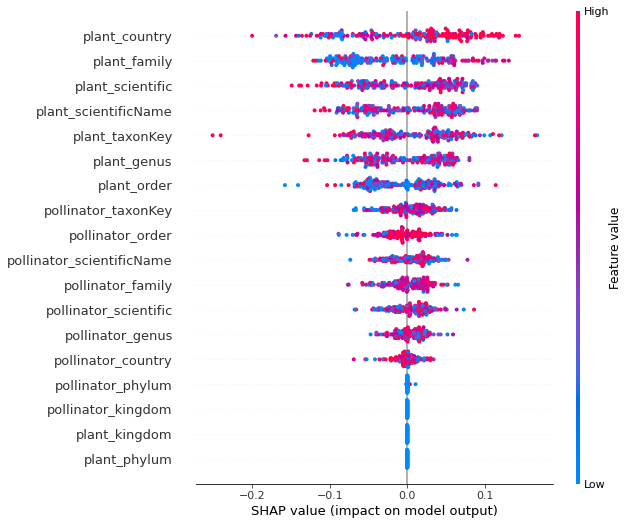

In [24]:
plt.figure()
summary_plot(shap_values[0], features=subsample_X_train, feature_names=PollPlants_drop2.columns)

PollPlants.fillna(value=-999, inplace=True)